In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

import shutil
from sklearn.model_selection import train_test_split

import os

In [2]:
# Define your directories
vehicle_dir = 'C:/Users/abbie/Documents/Deep Learning/Vehicle Classification/data/vehicles'
non_vehicle_dir = 'C:/Users/abbie/Documents/Deep Learning/Vehicle Classification/data/non-vehicles'

# Function to get file paths
def get_file_paths(directory):
    return [os.path.join(directory, f) for f in os.listdir(directory)]

# Get file paths
vehicle_files = get_file_paths(vehicle_dir)
non_vehicle_files = get_file_paths(non_vehicle_dir)

# Combine and label data (1 for vehicle, 0 for non-vehicle)
X = vehicle_files + non_vehicle_files
y = np.array([1] * len(vehicle_files) + [0] * len(non_vehicle_files))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Convert labels to strings for compatibility
y_train_str = [str(label) for label in y_train]
y_test_str = [str(label) for label in y_test]

In [4]:
# Creating DataFrames for training and validation
train_df = pd.DataFrame({'filename': X_train, 'class': y_train_str})
validation_df = pd.DataFrame({'filename': X_test, 'class': y_test_str})

In [5]:
# ImageDataGenerator for training (with augmentation) and validation (without augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# Define target size 64x64 since image set is 64x64
target_size = (64, 64)
batch_size = 32

# Creating generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 14208 validated image filenames belonging to 2 classes.


In [7]:
validation_generator = test_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='filename',
    y_col='class',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 3552 validated image filenames belonging to 2 classes.


In [10]:
# Define a simple CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 128)       

In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)


Epoch 1/10
444/444 [==============================] - 63s 139ms/step - loss: 0.2292 - accuracy: 0.9013 - val_loss: 0.1066 - val_accuracy: 0.9589
Epoch 2/10
444/444 [==============================] - 79s 177ms/step - loss: 0.1037 - accuracy: 0.9625 - val_loss: 0.0692 - val_accuracy: 0.9744
Epoch 3/10
444/444 [==============================] - 82s 184ms/step - loss: 0.0711 - accuracy: 0.9736 - val_loss: 0.0342 - val_accuracy: 0.9879
Epoch 4/10
444/444 [==============================] - 70s 157ms/step - loss: 0.0693 - accuracy: 0.9756 - val_loss: 0.0363 - val_accuracy: 0.9896
Epoch 5/10
444/444 [==============================] - 93s 209ms/step - loss: 0.0549 - accuracy: 0.9809 - val_loss: 0.0550 - val_accuracy: 0.9842
Epoch 6/10
444/444 [==============================] - 83s 186ms/step - loss: 0.0522 - accuracy: 0.9825 - val_loss: 0.0228 - val_accuracy: 0.9921
Epoch 7/10
444/444 [==============================] - 97s 220ms/step - loss: 0.0504 - accuracy: 0.9818 - val_loss: 0.1019 - val_ac

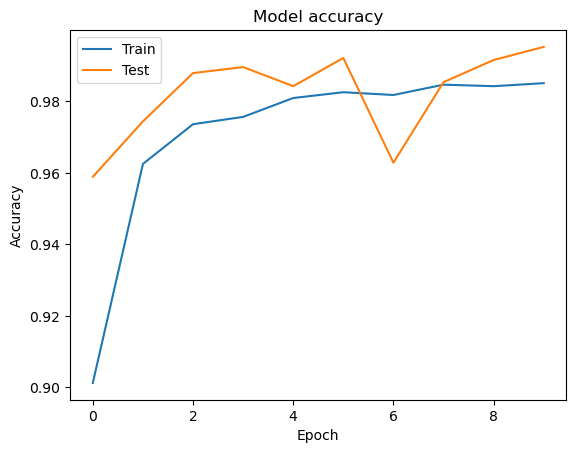

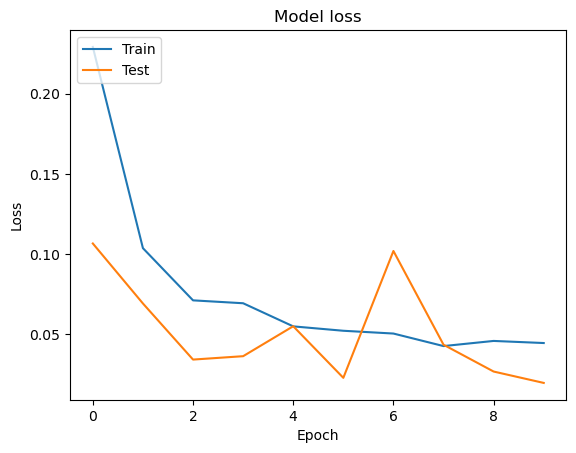

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [13]:
test_loss, test_accuracy = model.evaluate(validation_generator, steps=len(validation_generator))
print("Test accuracy:", test_accuracy)
print("Test loss:", test_loss)


111/111 [==============================] - 4s 33ms/step - loss: 0.0197 - accuracy: 0.9952
Test accuracy: 0.9952139854431152
Test loss: 0.01965852826833725


In [23]:
def predict_and_show_image(model, image_path, target_size=(64, 64)):
    # Load and display the image
    img = load_img(image_path, target_size=target_size)
    plt.imshow(img)
    plt.axis('off')

    # Resize for model prediction
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Make a prediction
    prediction = model.predict(img_array)

    # Determine the predicted class
    predicted_class = 'Vehicle' if prediction[0][0] > 0.5 else 'Non-Vehicle'

    # Show the predicted class
    plt.title(f"Predicted class: {predicted_class}")
    plt.show()

    return prediction

1/1 [==============================] - 0s 90ms/step


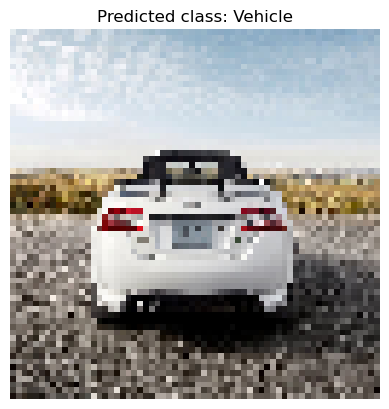

In [32]:
new_image_path = 'car.jpeg'
prediction = predict_and_show_image(model, new_image_path)


1/1 [==============================] - 0s 82ms/step


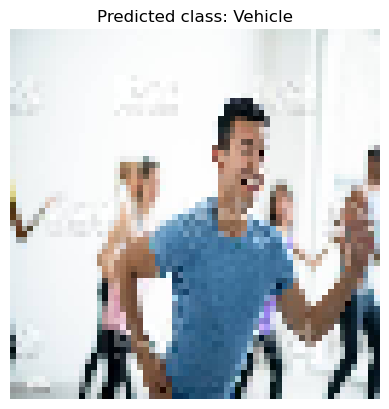

In [33]:
new_image_path = 'simu_liu.jpg'
prediction = predict_and_show_image(model, new_image_path)
